# Milestone - Random Forets

This notebook corresponds to the third stage of the Machine Learning final project, as part of the Copernicus Master in Digital Earth, in the Data Science track at University of South Brittany, Vannes, France by Candela Sol PELLIZA & Rajeswari PARASA.

We demonstrate the use of Random Forests for the regression probelm of predicting housing prices in Ames, Iowa. In this workflow, we conduct hyperparameter tuning using OOB score, grid search and cross validation; evaluate feature importance; perform feature selection; and then evaluate the model on the test set. We then compare the results of the model with and without feature selection, and also with the linear regressor previously modelled.

### 1. Data importing

In [1]:
# Loading libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score, make_scorer
import seaborn as sns
import warnings

The first step consists on importing the csv fieles for train and test dataset. We will skip the train and test split, as they were already divided in the previous preprocessing steps, and used the test and train files we exported in Milestone 2 Notebook.

The csv datasets files can be obtained by running the mentioned Notebook or can be directly downloaded from the [GitHub Repository](https://github.com/rajesvariparasa/ml-processing-pipeline-for-predicting-houseprices/tree/main/OpenData).

In [2]:
# Import train and test datasets in csv format
data_train = pd.read_csv('OpenData/ames_train_clean.csv')
data_test = pd.read_csv('OpenData/ames_test_clean.csv')

As a second step, we will connvert the train and test datasets into NumPy arrays, extracting also the variables' names as an independent vector.

In [3]:
# Creating train and test dataframes
X_train = data_train.drop(columns = ['PID', 'SoldPrice'])
X_test = data_test.drop(columns = ['PID', 'SoldPrice'])
X_names = data_train.drop(columns = ['PID', 'SoldPrice']).columns.tolist()

Y_train = data_train['SoldPrice']
Y_test = data_test['SoldPrice']

After that, as done in the previous notebook, we will define our own score metrics, which correspond to the accuracy metrics we defined at the start of the project (`RMSE`, `RMSLE` and `R2`)

In [11]:
# Function for calculating RMSE
def rmse(y_test, y_pred):
    """
    This function calculates the RMSE between the predicted and the actual values
    -------------------------------------------
    Parameters:
    y_test (array): Array of actual values
    y_pred (array): Array of predicted values

    Returns:
    float: RMSE value
    """
    
    return mean_squared_error(y_test, y_pred, squared=False)
# Define a custom scorer for RMSE
rmse_scorer = make_scorer(rmse, greater_is_better=False)

def rmsle(y_test, y_pred):
    """
    This function calculates the RMSLE between the predicted and the actual values
    -------------------------------------------
    Parameters:
    y_test (array): Array of actual values
    y_pred (array): Array of predicted values
    
    Returns:
    float: RMSLE value
    """
    return mean_squared_log_error(y_test, y_pred, squared=False)

# Define a custom scorer for RMSLE
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

# Define a custom scorer for R2
r2_scorer = make_scorer(r2_score)

### 2. Hyperparameter tuning
In this notebook, we will apply a random forest model to predict the properties' sold price, as we did previously with the linear regression models. For this, as we have a regression problem, we will use the scikit function `RandomForestRegressor()`

The random forest model requires tuning two main parameters:

- **`n_estimators`:** number of trees in the forest
- **`max_features`:** number of features to take into account when looking for the best split

The tuning will be done in two steps: 

First we will tune the `n_estimators` parameter, with `max_features=None.`
Once we have found the `n_estimators` optimal parameter, we will tune `max_features` using `gridsearchCV` to find the value that gives the best performance. 
Finally we will check again the `n_estimators` parameter, with the newly defined `max_features`, to see if an adjustment is necessary.

#### 2.1. Tuning `n_estimators`
We will first tune the `n_estimators` paramater. For this step, `max_features` is set to None, which will consider the total number of variables. 

We will calculate the OOB error for random forest models with different numbers of trees, from a minimum of 100 to a maximum of 1500 in steps of 50. Finally, the OOB error will be plotted for each n_estimators tested value for visually inspecting at which value the error stabilizes.

In [6]:
# Create an empty list for OBB error and i values iteration
error_rate1 = []
i_list1 = []

# Define a loop to iterate over the different values of n_estimators
for i in range(10, 300, 10):
    
    # warm_start = true: reuse the solution of the previous iteration, adding more estimators (otherwise a whole new tree would be created)
    # random_state = 33: allows reproducibility, giving the same results each time the code block is ran
    # oob_score = true: sets oob score as the metric for generalisation score
   
    rf = RandomForestRegressor(warm_start=True, n_estimators=i, max_features=None, random_state=33, oob_score=True)
    rf.fit(X_train, Y_train)

    # oob_score attribute returns the accuracy, but we are interested on the error itself (then: 1-oob_score)
    oob_error = 1 - rf.oob_score_

    # Append OOB error rate and i values to the lists
    error_rate1.append(oob_error)
    i_list1.append(i)

c:\Users\cande\anaconda3\envs\scientific\lib\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


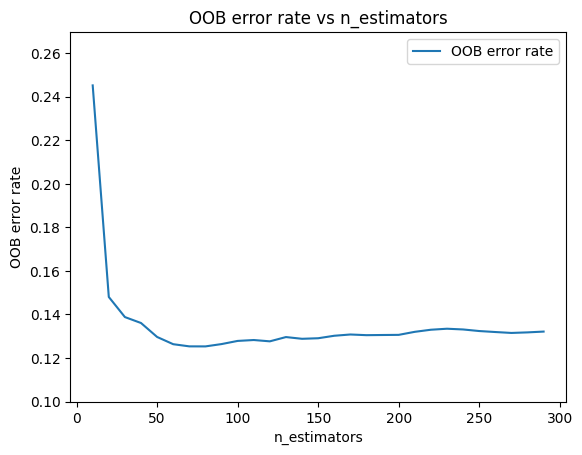

In [ ]:
# Plot n_esitmators vs OOB error

plt.plot(i_list1, error_rate1, label="OOB error rate")
plt.ylim(0.1, 1.1*max(error_rate1)) 
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.title("OOB error rate vs n_estimators")
plt.legend(loc="upper right")
plt.show()

Based on the obtained graphic, we can conclude that the OOB error gets stabilized when `n_estimators` reaches 200. Consequently, we will use this value for the model and for calibrating the next hyperparameter - `max_features`.

#### 2.2 Tuning max_features
Once we have tuned the `n_estimators` parameter, we will use that for tuning the `max_features` parameter. 

We will tune this parameter using Cross Validation technique, with 5 k-folds, which means that 20% of the data will be used for testing purpose at each iteration, which is a generalized standard value for this task.

We will tune the hyperparameter based on the acuracy and std scores of our main accuracy metric defined at the beggining of the project, `RMSLE`.


In [12]:
# Define scoring metrics
scoring = {'RMSLE': rmsle_scorer}

# Create a dict of possible max_features values
cv_vals = {'max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}

# Define the model
# n_estimators=200 based on the previous parameter tuning step
# random_state = 33: allows reproducibility, giving the same reuslts each time the notebook is ran
# n_jobs =-1 to use all the cores of the computer
rf = RandomForestRegressor(n_estimators=200, random_state=33, n_jobs=-1)

# cv=5 for 5 k-folds
# scoring gets the defined scoring metrics
# refit=Flase allows calculaitng more than one metric
gridsearch_cv1 = GridSearchCV(estimator=rf, param_grid=cv_vals, cv=5, scoring=scoring, refit= False)
gridsearch_cv1.fit(X_train, Y_train)

results_cv1=pd.DataFrame(gridsearch_cv1.cv_results_)[["params", "mean_test_RMSLE", "std_test_RMSLE"]]
print(round(results_cv1, 2))

                  params  mean_test_RMSLE  std_test_RMSLE
0  {'max_features': 0.1}            -0.13            0.03
1  {'max_features': 0.2}            -0.13            0.03
2  {'max_features': 0.3}            -0.13            0.03
3  {'max_features': 0.4}            -0.13            0.03
4  {'max_features': 0.5}            -0.13            0.03
5  {'max_features': 0.6}            -0.14            0.03
6  {'max_features': 0.7}            -0.14            0.03
7  {'max_features': 0.8}            -0.14            0.03
8  {'max_features': 0.9}            -0.14            0.03


According to the results obtained with CrossValidation, we will tune the max_features parameter to 0.4. This is because 0.4 is one of the values that show a better trade-off between RMSLE score and standard deviation, but takes a considerable proportion of features.

#### 2.3. Re-testing n_estimators value
As the value of `max_features` changed, after tuning, from the one that was originally considered when tuning `n_estimators`, we will test again if `n_estimators`=`200` is a good value for a random forest model with `max_features`=`0.4`

In [14]:
# Create an empty list for OBB error and i values iteration
error_rate = []
i_list = []

# Define a loop to iterate over the different values of n_estimators
for i in range(10, 300, 10):
    # We use the same configuration as in the tuning, but now max_features= 0.4
    # n_jobs =-1 to use all the cores of the computer
    rf = RandomForestRegressor(warm_start=True, n_estimators=i, max_features=0.4, random_state=33, oob_score=True, n_jobs=-1)
    rf.fit(X_train, Y_train)

    # oob_score attribute returns the accuracy, but we are interested on the error itself (then: 1-oob_score)
    oob_error = 1 - rf.oob_score_

    # Append OOB error rate and i values to the lists
    error_rate.append(oob_error)
    i_list.append(i)
    

c:\Users\cande\anaconda3\envs\scientific\lib\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


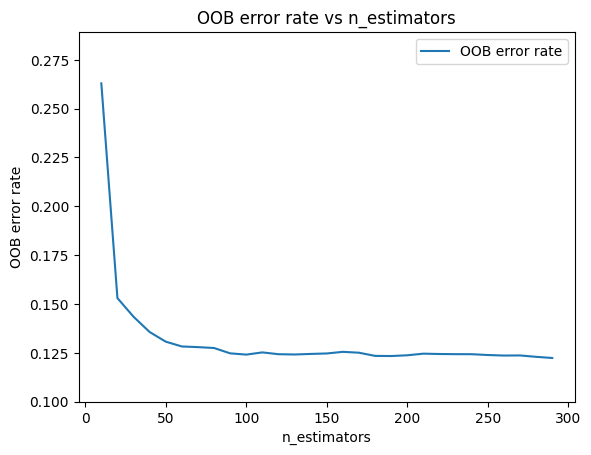

In [15]:
# Plot n_esitmators vs OOB error
plt.plot(i_list, error_rate, label="OOB error rate")
plt.ylim(0.1, 1.1*max(error_rate)) 
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.title("OOB error rate vs n_estimators")
plt.legend(loc="upper right")
plt.show()

We can see that, even after changing the max_features parameter value, n_estimators=200 shows to continue being a good stabilization value for OOB error.

#### 2.4. Applying the final Random Forest model
Now we will train the final model with the tuned hyperparameters and compute the OOB error.

In [16]:
rf1 = RandomForestRegressor(n_estimators = 200, max_features= 0.4, oob_score=True, random_state=33)
# Step 2: build the random forest on the train set by indicating the input data and the target variable 
rf1.fit(X_train, Y_train)

RandomForestRegressor(max_features=0.4, n_estimators=200, oob_score=True,
                      random_state=33)

In [17]:
# OOB error
print(f'OOB error: {round(1-rf1.oob_score_, 2)}')

OOB error: 0.12


We can observe that the random forest model, trained with the tuned parameters, gives an OOB error equal to 0.12. This is a good approximation on how the model would perform with unseen data.

### 2. Measure the importance of variables
Once the final model is trained, we will analyze the importance of the different variables. For this we will use the Mean Decrease in Accuracy metric (MDA), which calculates the difference between the error of the forest on Tm and the error of the forestpermuted sample e T jm. We decide to use this metric instead of Gini Impurity, other popular metric, because MDA has been demonstrated to be more robust when dealing with variables of different scales and when there are correlations between predictive variables (Nicodemus, 2011 & Han et al. 2016). These two characteristics are present in our dataset as it was analyzed in the EDA.

The n_repeats parameter stablishes the number of times that a feature is randomly shuffled and permuted. In this case, it is set to 10, given that the default value is 5, and multiplying that by 2 seems to be a good trade off for obtaining a better model without increasing too much the computational cost.

In [18]:
result = permutation_importance(rf1, X_train, Y_train, n_repeats=10, random_state=33, n_jobs=-1)

We will plot now the the results of the permutation importance, showing only the 15 more important features.

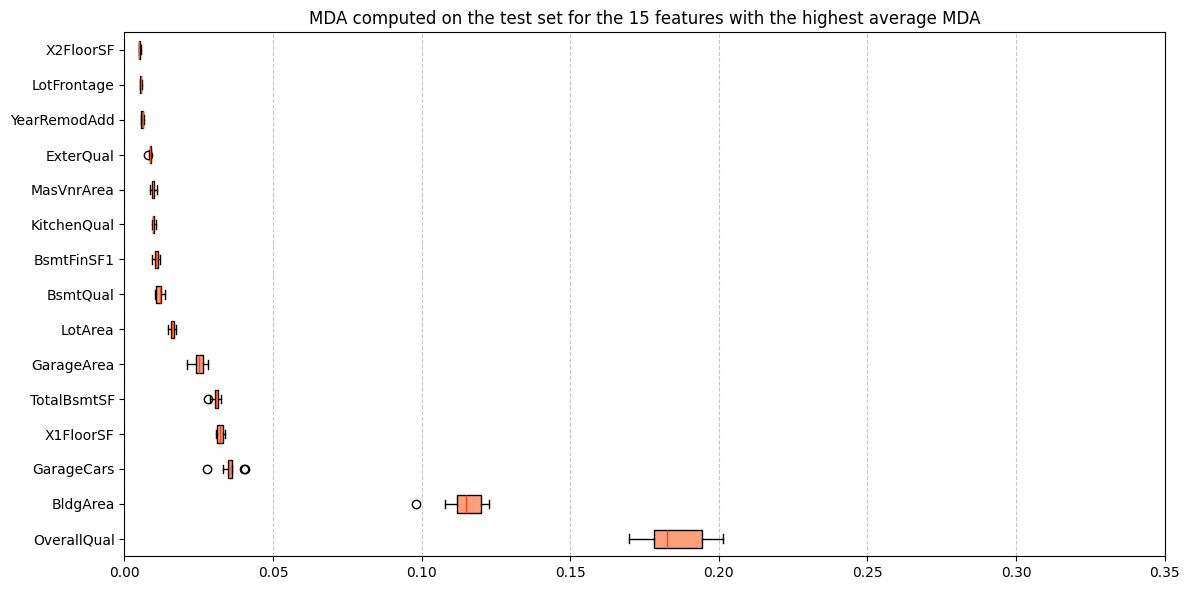

In [19]:
# Plot of the MDA for the 15 features with the highest average MDA
sorted_idx = result.importances_mean.argsort()
invert_sorted_idx = sorted_idx[::-1][:15]  # keep only the 15 features with the highest average MDA
fig, ax = plt.subplots(figsize=(12, 6))

# Use patch_artist=True to modify the box filling color
bp = ax.boxplot(result.importances[invert_sorted_idx].T, vert=False, labels=X_train.columns[invert_sorted_idx], patch_artist=True)

# Set the box filling color for all boxes
for box in bp['boxes']:
    box.set_facecolor('lightsalmon')

# Set the median line color for all medians
for median in bp['medians']:
    median.set_color('orangered')

# Add grid lines
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Increase the size of the x-axis interval
ax.set_xlim(0, 0.35)

ax.set_title("MDA computed on the test set for the 15 features with the highest average MDA")
fig.tight_layout()
plt.show()

The variable importance analysis shows Overall Quality and Building Area as the two main variables, with a big distance from the following one. This is congruent with waht we have seen in the linear regression model analysis, where the same variables showed the highest correlation with the target variable 'Sold Price'

### 3. Variable selection
In this section we will select the variables that will be used for training the final model. For this, we use Boruta feature selection strategy. The Boruta algorithm iteratively removes the features of less relevance to the prediction, based on a statistical test [(Kursa & Rudnicki, 2010)](https://www.jstatsoft.org/article/view/v036i11). The [Boruta python package](https://github.com/scikit-learn-contrib/boruta_py) provides an implementation of this algorithm.

We pick Boruta because of three reasons: **One**, it overcomes the *minimal-optimal* problem. Minima-optimal problem occurs when a feature selection algorithm selects a minimal set of features that provide best possible prediction results [(Nilsson, Pe˜na, Bj¨orkegren, and Tegn´er 2007)](https://www.researchgate.net/publication/220320569_Consistent_Feature_Selection_for_Pattern_Recognition_in_Polynomial_Time). But Boruta allows for a selection of *all relevant* features [(Kursa & Rudnicki, 2010)](https://www.jstatsoft.org/article/view/v036i11). This is useful when exploring a dataset has a large set of features. **Two**, we do not want to specify the number of variables to be selected, in case we miss out on important ones due to such a limit, this is a limitation with Recurisve Feature Elimination (RFE) because the user needs to specify this limit [(Samo, 2022)](https://blog.kxy.ai/effective-feature-selection/index.html#limits). And **finally**, Boruta requires far fewer iterations compared to RFE, which can be an advantage when working with large datasets *(Ibid)*. 

#### 3.a. Setting up the Boruta algorithm
We will first install the boruta package and import it, and make necessary datatype corrections to the boruta.py file to make the implementation compatible with the latest numpy version. This is because the boruta package has not been updated for the latest version of numpy ([issue 120](https://github.com/scikit-learn-contrib/boruta_py/issues/120), [issue 122](https://github.com/scikit-learn-contrib/boruta_py/issues/122)).

We then initialize the boruta algorithm with the RandomForestRegressor model, and fit it to the training data.

Instructions before using boruta:
1. Install the package using `!pip install boruta`
2. Make the following changes to the boruta.py file in case the following code blocks throw an error. Change all the occurances of these datatypes:
    - `np.int` to `np.int32`, 
    - `np.float` to `np.float64` and 
    - `np.bool` to `np.bool_` in the boruta.py file. 

In [21]:
#  !pip install Boruta
from boruta import BorutaPy

The Boruta algorithm is created as a wrapper around a random forest estimator. The algorithm suggests that we can pass the `n_estimators` and `max_features` values that are suitable to the dataset [(Kursa & Rudnicki, 2010)](https://www.jstatsoft.org/article/view/v036i11) to initialize a random forest estimator (or leave model defaults, if unknown). We calibrated these parameter values in the previous section, so we will use them in constructing our random forest model to be used as an estimator for the Boruta algorithm.

In [22]:
# We use n_jobs =-1 to use all the cores of the computer, we set random_state=33 for reproducibility

rf = RandomForestRegressor(n_estimators=200,n_jobs=-1, max_features=0.4,oob_score=True,random_state=33)
rf.fit(X_train, Y_train)

# define Boruta feature selection method
boruta = BorutaPy(rf, n_estimators=200, random_state=33)

# find all relevant features
boruta.fit(X_train.values, Y_train.values)

BorutaPy(estimator=RandomForestRegressor(max_features=0.4, n_estimators=200,
                                         n_jobs=-1, oob_score=True,
                                         random_state=RandomState(MT19937) at 0x20D040DBB40),
         n_estimators=200, random_state=RandomState(MT19937) at 0x20D040DBB40)

#### 3.b. Selecting the relevant features
We will now inspect all the features identified as relevant as important by Boruta. For this we use the attributes of the Boruta object, namely, `.support_`, `.ranking_` and `.support_weak_`

In [23]:
# To check the selected features
boruta.support_

array([ True,  True,  True, False, False, False, False, False,  True,
       False,  True,  True,  True,  True, False,  True, False, False,
       False,  True, False, False, False,  True, False, False,  True,
        True, False, False,  True, False, False, False,  True,  True,
       False, False, False,  True, False,  True,  True, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [24]:
# To check the ranking of the features
boruta.ranking_

array([  1,   1,   1, 167,  56,  36, 169,  34,   1,   9,   1,   1,   1,
         1,  39,   1,  97,  22,  12,   1,  78,  59,   2,   1,  18, 108,
         1,   1,  11,  54,   1,  17,  11,  81,   1,   1,  46,   5,   3,
         1,  22,   1,   1,  85,  77, 108,   5,   1,  71, 121,   7, 130,
       169,  88,  73,   3,  20,  58, 155,  92,  14, 159, 166,  91, 135,
        76,  93,  49, 170, 148,  96, 158,  61,  35,  13,  27,  51,  19,
        74,  54, 115, 122,  64, 121,  84, 158, 105,  72,  29,   8, 114,
       164, 164, 119,  64,  89,  24,  37, 127, 154, 111, 103,  60,  15,
        95,  44, 135, 100,  65,  88, 101, 132, 149, 175, 137, 181, 106,
       123, 103,  31, 143,  75,  90,  98,  86,  40, 146,  25, 140, 109,
       162,  34, 180,  16,  84, 127,  47, 179, 145, 151,  52, 130, 127,
        41,  23,  57, 103, 141,  32,  79, 153, 156, 176,  69,  28, 124,
        71, 165, 100, 145,  30,  69,  94, 112,  54, 118,  62, 136,  27,
         6, 127, 179, 173, 182, 133, 139, 116, 160,  39, 143,  8

In [25]:
# Collect the selected features in a list
boruta_subset = [f for f,s in zip(X_train.columns, boruta.support_) if s]
print(boruta_subset)
print(len(boruta_subset))

['BldgArea', 'LotFrontage', 'LotArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'BsmtQual', 'BsmtFinSF1', 'TotalBsmtSF', 'X1FloorSF', 'X2FloorSF', 'FullBath', 'KitchenQual', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'OpenPorchSF']
20


In [27]:
# we can use .support_weak_ to check for weakly relevant features 
# it is up to us whether we want to keep them or not
weakly_relevant = boruta.support_weak_ 
boruta_weak_subset = [f for f,s in zip(X_train.columns, boruta.support_weak_) if s]
print(boruta_weak_subset)
print(len(boruta_weak_subset))

['BsmtUnfSF']
1


Boruta has selected the following 20 variables as relevant for the prediction:

`BldgArea`, `LotFrontage`, `LotArea`, `OverallQual`, `YearBuilt`, `YearRemodAdd`, `MasVnrArea`, `ExterQual`, `BsmtQual`, `BsmtFinSF1`, `TotalBsmtSF`, `X1FloorSF`, `X2FloorSF`, `FullBath`, `KitchenQual`, `GarageCars`, `GarageArea`, `OpenPorchSF`

We can use these variables to train the final model. It also selected onw weakly relevant features, `TotRmsAbvGrd` which we will not use for training the final model. However, we will revisit these features *if* required, after evaluating the model performance with the selected features.

In [28]:
# this codeblock is just to check how much the results match with the MDA - we dont use this intersection for training
intersection = np.intersect1d(boruta_subset,X_train.columns[invert_sorted_idx])
print(intersection)
print(len(intersection))

['BldgArea' 'BsmtFinSF1' 'BsmtQual' 'ExterQual' 'GarageArea' 'GarageCars'
 'KitchenQual' 'LotArea' 'LotFrontage' 'MasVnrArea' 'OverallQual'
 'TotalBsmtSF' 'X1FloorSF' 'X2FloorSF' 'YearRemodAdd']
15


We observe that all the top 15 features observed in MDA feature importance are also selected by Boruta. This is a good sign that the variables selected by Boruta are indeed relevant for the prediction. We do not want to take an intersection/subset of the variables selected by Boruta and the top 15 variables from MDA because we want to keep 'all relevant' features as discussed above. Hence we only take the Boruta selected variables for training the final model.

### 4. Evaluate test performance

In this section we will evaluate the performance of the final model on the test dataset. We will first use the entire feature set to train the model and then use only the boruta subset. We will use the same metrics as before, RMSLE and R2.

In [29]:
# function to plot actual and predicted values along with x=y line
def plot_Yt_Yp(y_test, y_pred, set_limit=None):
    """
    Plots the actual vs predicted values
    ------------------------------------
    Parameters:
    y_test: actual values
    y_pred: predicted values

    Returns:
    None
    """
    plt.scatter(y_test, y_pred, alpha=0.3, label= 'Property Sold')
    plt.xlabel('Actual Sold Price')
    plt.ylabel('Predicted Sold Price')
    plt.title('Actual vs Predicted Sold Price')
    # Set axis limits if set_limit parameter is provided
    if set_limit:
        plt.axis(set_limit)
    #plot x=y line
    plt.plot(np.linspace(np.min(y_test), np.max(y_test), 1000), np.linspace(np.min(y_test), np.max(y_test) , 1000), color='red', label= 'x=y line')
    plt.legend()
    plt.show()

#### 4.a. Model trained using all features

RMSLE on test set:  0.13
R2 on test set:  0.89
RMSE on test set:  30489.41


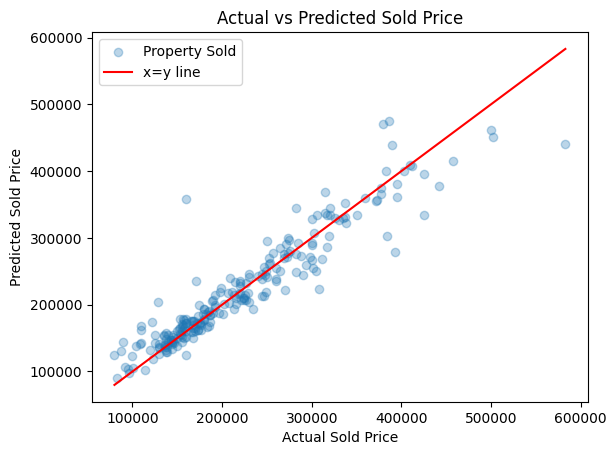

In [30]:
rf1 = RandomForestRegressor(n_estimators = 200, n_jobs=-1, max_features= 0.5, oob_score=True, random_state=33)
rf1.fit(X_train, Y_train)
y_pred1 = rf1.predict(X_test)
print('RMSLE on test set: ', round(rmsle(Y_test, y_pred1),2))
print('R2 on test set: ', round(rf1.score(X_test, Y_test),2))
print('RMSE on test set: ', round(rmse(Y_test, y_pred1),2))
plot_Yt_Yp(Y_test, y_pred1)

We observe from this graph that the plot between actual vs predicted prices (full feature set) reasonably follows the x=y line. A keener observation is that it performs better for properties sold in the lower price ranges than at higher price ranges. This is because, divergence from the x=y line increases as the Sold price increases. The RMSLE is 0.13, the RMSE is 30489.41 and the R2 is 0.89. This is a good performance for the model.

#### 4.b. Model trained using Boruta selected features

RMSLE on test set:  0.13
R2 on test set:  0.89
RMSE on test set:  29933.96


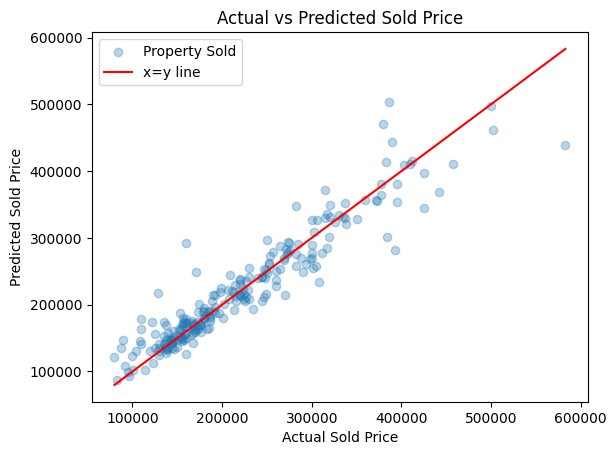

In [31]:
# Using the subset of variables selected by Boruta
X_train_new = X_train[boruta_subset]
X_test_new = X_test[boruta_subset]

rf2 = RandomForestRegressor(n_estimators = 200, n_jobs=-1, max_features= 0.5, oob_score=True, random_state=33)
rf2.fit(X_train_new, Y_train)
y_pred2 = rf2.predict(X_test_new)
print('RMSLE on test set: ', round(rmsle(Y_test, y_pred2),2))
print('R2 on test set: ', round(rf2.score(X_test_new, Y_test),2))
print('RMSE on test set: ', round(rmse(Y_test, y_pred2),2))
plot_Yt_Yp(Y_test, y_pred2)

We observe from this graph that the plot between actual vs predicted prices (Boruta subset) shows a similar behavior as the previous plot (model trained on the full set), except for a few outliers. Interestingly, the R2 and RMSLE are also same as the model trained with the full feature set. This is a (good) sign that the Boruta selected features are indeed relevant for the prediction. Moreover, when analyzing RMSE, we see that this metric shows even a smaller error for the Boruta selected features model than when using all the features.

It is safe to say that the model trained with the Boruta selected features performs as well (and even better) than the model trained with the full feature set. This is a good result because we can now use the Boruta selected features to train the model, which will reduce the computational cost of the model.

#### Conclusions

1. **Configuration of the best model**: The best model is a random forest model with `n_estimators` = 200 trees and `max_features`= 0.5. This model has an OOB error of 0.13, which is a good approximation of the error that the model would have with unseen data. The model can be trained with the subset of variables selected by Boruta algorithm, which are 20 variables. These are: `BldgArea`, `LotFrontage`, `LotArea`, `OverallQual`, `YearBuilt`, `YearRemodAdd`, `MasVnrArea`, `ExterQual`, `BsmtQual`, `BsmtFinSF1`, `TotalBsmtSF`, `X1FloorSF`, `X2FloorSF`, `FullBath`, `KitchenQual`, `TotRmsAbvGrd`, `GarageYrBlt`, `GarageCars`, `GarageArea`, `OpenPorchSF`

2. **Comparison between models trained on full feature set and Boruta subset**: We observe that the values of our chosen evaluation metrics are the same for both the full feature set and the model trained with Boruta selected subset **(R2=0.89, RMSLE=0.13)**. However, when checking RMSE, we see that the model eprforms even better for the Boruta subset model **(RMSE=29936 in Boruta subset vs RMSE=30489 in original model)**. We can conclude that the model trained with the subset of variables is really similar, and even a bit better than the one trained with the full set of variables. This is a very good result, as it means that we can use a model with less variables, which is easier to interpret, without losing performance.

3. **Comparison with linear regression from previous milestone**: In our previous milestone we explored linear regression models - with and without regularization. In case of without regularization, we obtained R2 of ~`-inf` and RMSLE couldn't be calculated. In case of ElasticNet regularization, we obtained an **R2 of 0.76** and an **RMSLE of 0.16**. When analyzing RMSE error, we can see that our prediction are, in average, almost 13000 dollars closer to the real value **(RMSE=29936 in Boruta subset RF vs RMSE=43809 in ElasticNet)**). We can conclude that our random forest model **(R2=0.89, RMSLE=0.14)** performs better than the ElasticNet model.

### References
Kristin K. Nicodemus, Letter to the Editor: On the stability and ranking of predictors from random forest variable importance measures, Briefings in Bioinformatics, Volume 12, Issue 4, July 2011, Pages 369–373, https://doi.org/10.1093/bib/bbr016

Hastie, T., Tibshirani, R., & Friedman, J. (2009). The Elements of Statistical Learning: Data Mining, Inference, and Prediction. Springer. URL: https://link.springer.com/book/10.1007/978-0-387-84858-7

Hong Han, Xiaoling Guo and Hua Yu, "Variable selection using Mean Decrease Accuracy and Mean Decrease Gini based on Random Forest," 2016 7th IEEE International Conference on Software Engineering and Service Science (ICSESS), Beijing, 2016, pp. 219-224, doi: 10.1109/ICSESS.2016.7883053.

Kursa, M. B., & Rudnicki, W. R. (2010). Feature Selection with the Boruta Package. Journal of Statistical Software, 36(11), 1 - 13. doi:http://dx.doi.org/10.18637/jss.v036.i11

Samo, K. (2022, January 3). Effective Feature Selection. Retrieved from https://blog.kxy.ai/effective-feature-selection/index.html#limits

Nilsson, R., Pe˜na, J. M., Bj¨orkegren, J., and Tegn´er, J. (2007). Consistent feature selection for pattern recognition in polynomial time. Journal of Machine Learning Research, 8:589–612.

**Acknowledgments:** Two AI Generative tools (ChatGPT and GitHub Copilot) were used as helping tools for code improvement and debugging. However, no content was directly taken from these sources.
